In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tq


In [2]:
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)

In [3]:
def make_mask(center,diam,z,width,height,spacing,origin):
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int((diam+5)/spacing[0])
    v_xmin = np.max([0,int(v_center[0]-v_diam)])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)])
    v_ymin = np.max([0,int(v_center[1]-v_diam)]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [4]:
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))


In [5]:
# pts = np.random.permutation(10)
# train_pts = pts[:6]
# val_pts = pts[6:8]
# test_pts = pts[8:]

In [6]:
# np.save('train_pts.npy',train_pts)
# np.save('val_pts.npy',val_pts)
# np.save('test_pts.npy',test_pts)

train_pts = np.load('train_pts.npy')
val_pts = np.load('val_pts.npy')
test_pts = np.load('test_pts.npy')

In [7]:
luna_path="../dataset/"
tr_output_img_path="../data/train/images/"
tr_output_mask_path="../data/train/labels/"

if not os.path.isdir(tr_output_img_path):
    os.makedirs(tr_output_img_path)
if not os.path.isdir(tr_output_mask_path):
    os.makedirs(tr_output_mask_path)

v_output_img_path="../data/val/images/"
v_output_mask_path="../data/val/labels/"

if not os.path.isdir(v_output_img_path):
    os.makedirs(v_output_img_path)
if not os.path.isdir(v_output_mask_path):
    os.makedirs(v_output_mask_path)
    
ts_output_img_path="../data/test/images/"
ts_output_mask_path="../data/test/labels/"

if not os.path.isdir(ts_output_img_path):
    os.makedirs(ts_output_img_path)
if not os.path.isdir(ts_output_mask_path):
    os.makedirs(ts_output_mask_path)


In [8]:
fcount = 0
for tr in list(train_pts):
    print('Set:',tr)
    luna_subset_path="../dataset/subset"+str(tr)+"/"
    file_list=glob(luna_subset_path+"*.mhd")
    df_node = pd.read_csv(luna_path+"annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    for img_file in tq(file_list):       
        #print "Getting mask for image file %s" % img_file.replace(luna_subset_path,"")
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
#         print(len(mini_df))
        if len(mini_df)>0:       # some files may not have a nodule--skipping those 
            biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
            node_x = mini_df["coordX"].values[biggest_node]
            node_y = mini_df["coordY"].values[biggest_node]
            node_z = mini_df["coordZ"].values[biggest_node]
            diam = mini_df["diameter_mm"].values[biggest_node]

            itk_img = sitk.ReadImage(img_file) 
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            center = np.array([node_x,node_y,node_z])   # nodule center
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            num_z, height, width = img_array.shape

            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing) 

            for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
                mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
                masks = mask
    #             imgs = matrix2int16(img_array[i_z])
                imgs = img_array[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)  
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the 
                # underflow and overflow on the pixel spectrum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
    #             print('orig:',img_array[i_z].max())
    #             print('int16:',imgs.max())
                np.save(tr_output_img_path+"images_"+str(fcount)+".npy",imgs)
                np.save(tr_output_mask_path+"masks_"+str(fcount)+".npy",masks)

                fcount +=1

Set: 6



Set: 7



Set: 0



Set: 9



Set: 4



Set: 8


In [9]:
fcount = 0
for val in list(val_pts):
    print('Set:',val)
    luna_subset_path="../dataset/subset"+str(val)+"/"
    file_list=glob(luna_subset_path+"*.mhd")
    df_node = pd.read_csv(luna_path+"annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    for img_file in tq(file_list):       
        #print "Getting mask for image file %s" % img_file.replace(luna_subset_path,"")
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
#         print(len(mini_df))
        if len(mini_df)>0:       # some files may not have a nodule--skipping those 
            biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
            node_x = mini_df["coordX"].values[biggest_node]
            node_y = mini_df["coordY"].values[biggest_node]
            node_z = mini_df["coordZ"].values[biggest_node]
            diam = mini_df["diameter_mm"].values[biggest_node]

            itk_img = sitk.ReadImage(img_file) 
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            center = np.array([node_x,node_y,node_z])   # nodule center
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            num_z, height, width = img_array.shape

            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing) 

            for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
                mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
                masks = mask
    #             imgs = mavalix2int16(img_array[i_z])
                imgs = img_array[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)  
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the 
                # underflow and overflow on the pixel specvalum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
    #             print('orig:',img_array[i_z].max())
    #             print('int16:',imgs.max())
                np.save(v_output_img_path+"images_"+str(fcount)+".npy",imgs)
                np.save(v_output_mask_path+"masks_"+str(fcount)+".npy",masks)

                fcount +=1

Set: 1



Set: 2


In [10]:
fcount = 0
for ts in list(test_pts):
    print('Set:',ts)
    luna_subset_path="../dataset/subset"+str(ts)+"/"
    file_list=glob(luna_subset_path+"*.mhd")
    df_node = pd.read_csv(luna_path+"annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    for img_file in tq(file_list):       
        #print "Getting mask for image file %s" % img_file.replace(luna_subset_path,"")
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
#         print(len(mini_df))
        if len(mini_df)>0:       # some files may not have a nodule--skipping those 
            biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]  # just using the biggest node
            node_x = mini_df["coordX"].values[biggest_node]
            node_y = mini_df["coordY"].values[biggest_node]
            node_z = mini_df["coordZ"].values[biggest_node]
            diam = mini_df["diameter_mm"].values[biggest_node]

            itk_img = sitk.ReadImage(img_file) 
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            center = np.array([node_x,node_y,node_z])   # nodule center
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            num_z, height, width = img_array.shape

#             center = np.array([node_x, node_y, node_z])   # nodule center
#             v_center = np.rint((center-origin)/spacing) 

            for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
                mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
                masks = mask
    #             imgs = matsix2int16(img_array[i_z])
                imgs = img_array[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)  
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the 
                # underflow and overflow on the pixel spectsum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
    #             print('orig:',img_array[i_z].max())
    #             print('int16:',imgs.max())
                np.save(ts_output_img_path+"images_"+str(fcount)+".npy",imgs)
                np.save(ts_output_mask_path+"masks_"+str(fcount)+".npy",masks)

                fcount +=1

Set: 3



Set: 5


In [11]:
#after this step the .mhd files are processed and saved into 2 .npy files
#image_* is npy of the image
#mask_* is npy of the  mask

In [12]:
print("value of x=",node_x)
print("value of y=",node_y)
print("value of z=",node_z)
print("value of diameter=",diam)

value of x= 123.02448270000001
value of y= 85.5951695
value of z= -215.17889559999998
value of diameter= 12.13515303


In [13]:
#imgs = np.ndarray([3,height,width],dtype=np.float32)#
#masks = np.ndarray([3,height,width],dtype=np.uint8)



(512, 512)
Img min: -1024 Img max: 3041


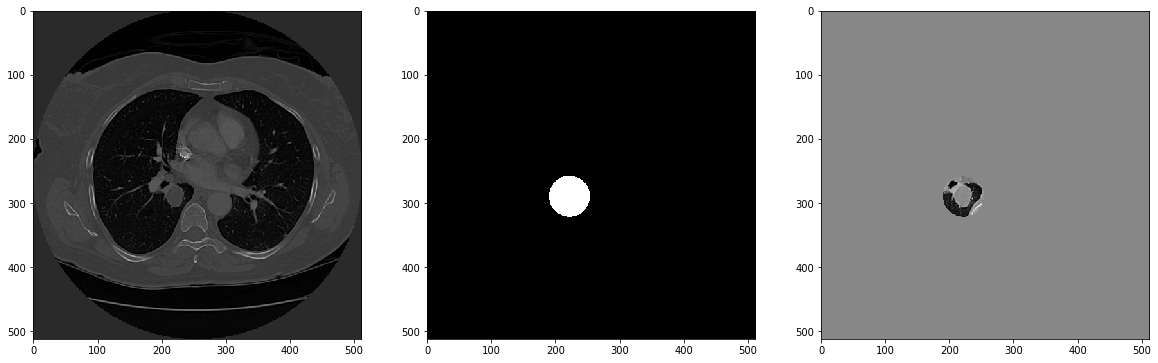

In [14]:
imgs = np.load(tr_output_img_path+'images_1.npy')
print(np.shape(imgs))
print('Img min:',imgs.min(),'Img max:',imgs.max())
# imgs[imgs==imgs.min()] = 0

masks = np.load(tr_output_mask_path+'masks_1.npy')

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs,cmap='gray')
plt.subplot(132)
plt.imshow(masks,cmap='gray')
plt.subplot(133)
plt.imshow((imgs)*masks,cmap='gray')

# imgs = np.load(output_path+'images_1.npy')
# masks = np.load(output_path+'masks_1.npy')

# plt.figure(figsize=[20,10])
# plt.subplot(131)
# plt.imshow(imgs,cmap='gray')
# plt.subplot(132)
# plt.imshow(masks,cmap='gray')
# plt.subplot(133)
# plt.imshow(imgs*masks,cmap='gray')

# imgs = np.load(output_path+'images_2.npy')
# masks = np.load(output_path+'masks_2.npy')

# plt.figure(figsize=[20,10])
# plt.subplot(131)
# plt.imshow(imgs,cmap='gray')
# plt.subplot(132)
# plt.imshow(masks,cmap='gray')
# plt.subplot(133)
# plt.imshow(imgs*masks,cmap='gray')

(512, 512)
Img min: -1024 Img max: 3041


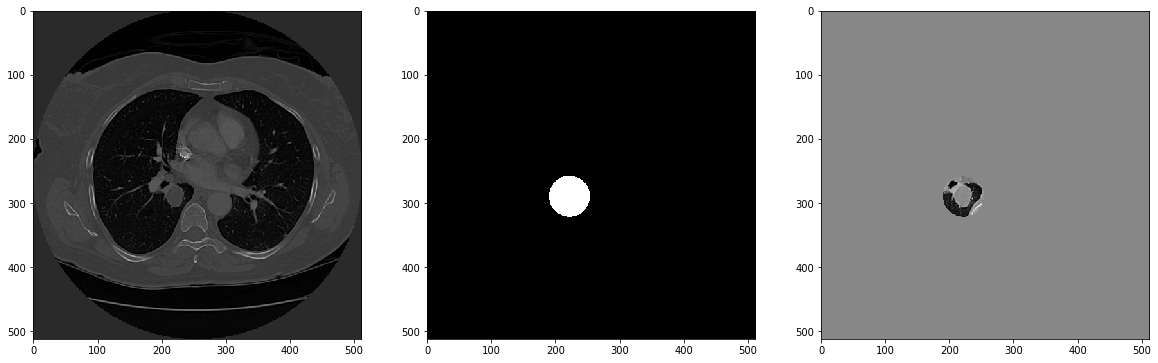

In [15]:
imgs = np.load(tr_output_img_path+'images_1.npy')
print(np.shape(imgs))
print('Img min:',imgs.min(),'Img max:',imgs.max())
# imgs[imgs==imgs.min()] = 0

masks = np.load(tr_output_mask_path+'masks_1.npy')

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs,cmap='gray')
plt.subplot(132)
plt.imshow(masks,cmap='gray')
plt.subplot(133)
plt.imshow((imgs)*masks,cmap='gray')
